In [1]:
import rl_ctrl_sat_aw
from scipy.integrate import ode
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Instantiate system

In [3]:
o = rl_ctrl_sat_aw.rl_ctrl_sat_aw_class()

## Solve steady state

In [4]:
%timeit optimize.root(o.run_problem, [1]*(o.N_x+o.N_y), method='hybr')

1.07 ms ± 60.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit optimize.root(o.run_problem, [1]*(o.N_x+o.N_y), jac=o.dae_jacobian, method='hybr')

330 µs ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
for it in range(o.N_x):
    print(o.x_list[it],o.struct[0].x[it])
for it in range(o.N_y):
    print(o.y_list[it],o.struct[0].y[it])

i [1.]
xi [0.01]
y [0.1]
v [0.1]


## Run single simulation

<IPython.core.display.Javascript object>


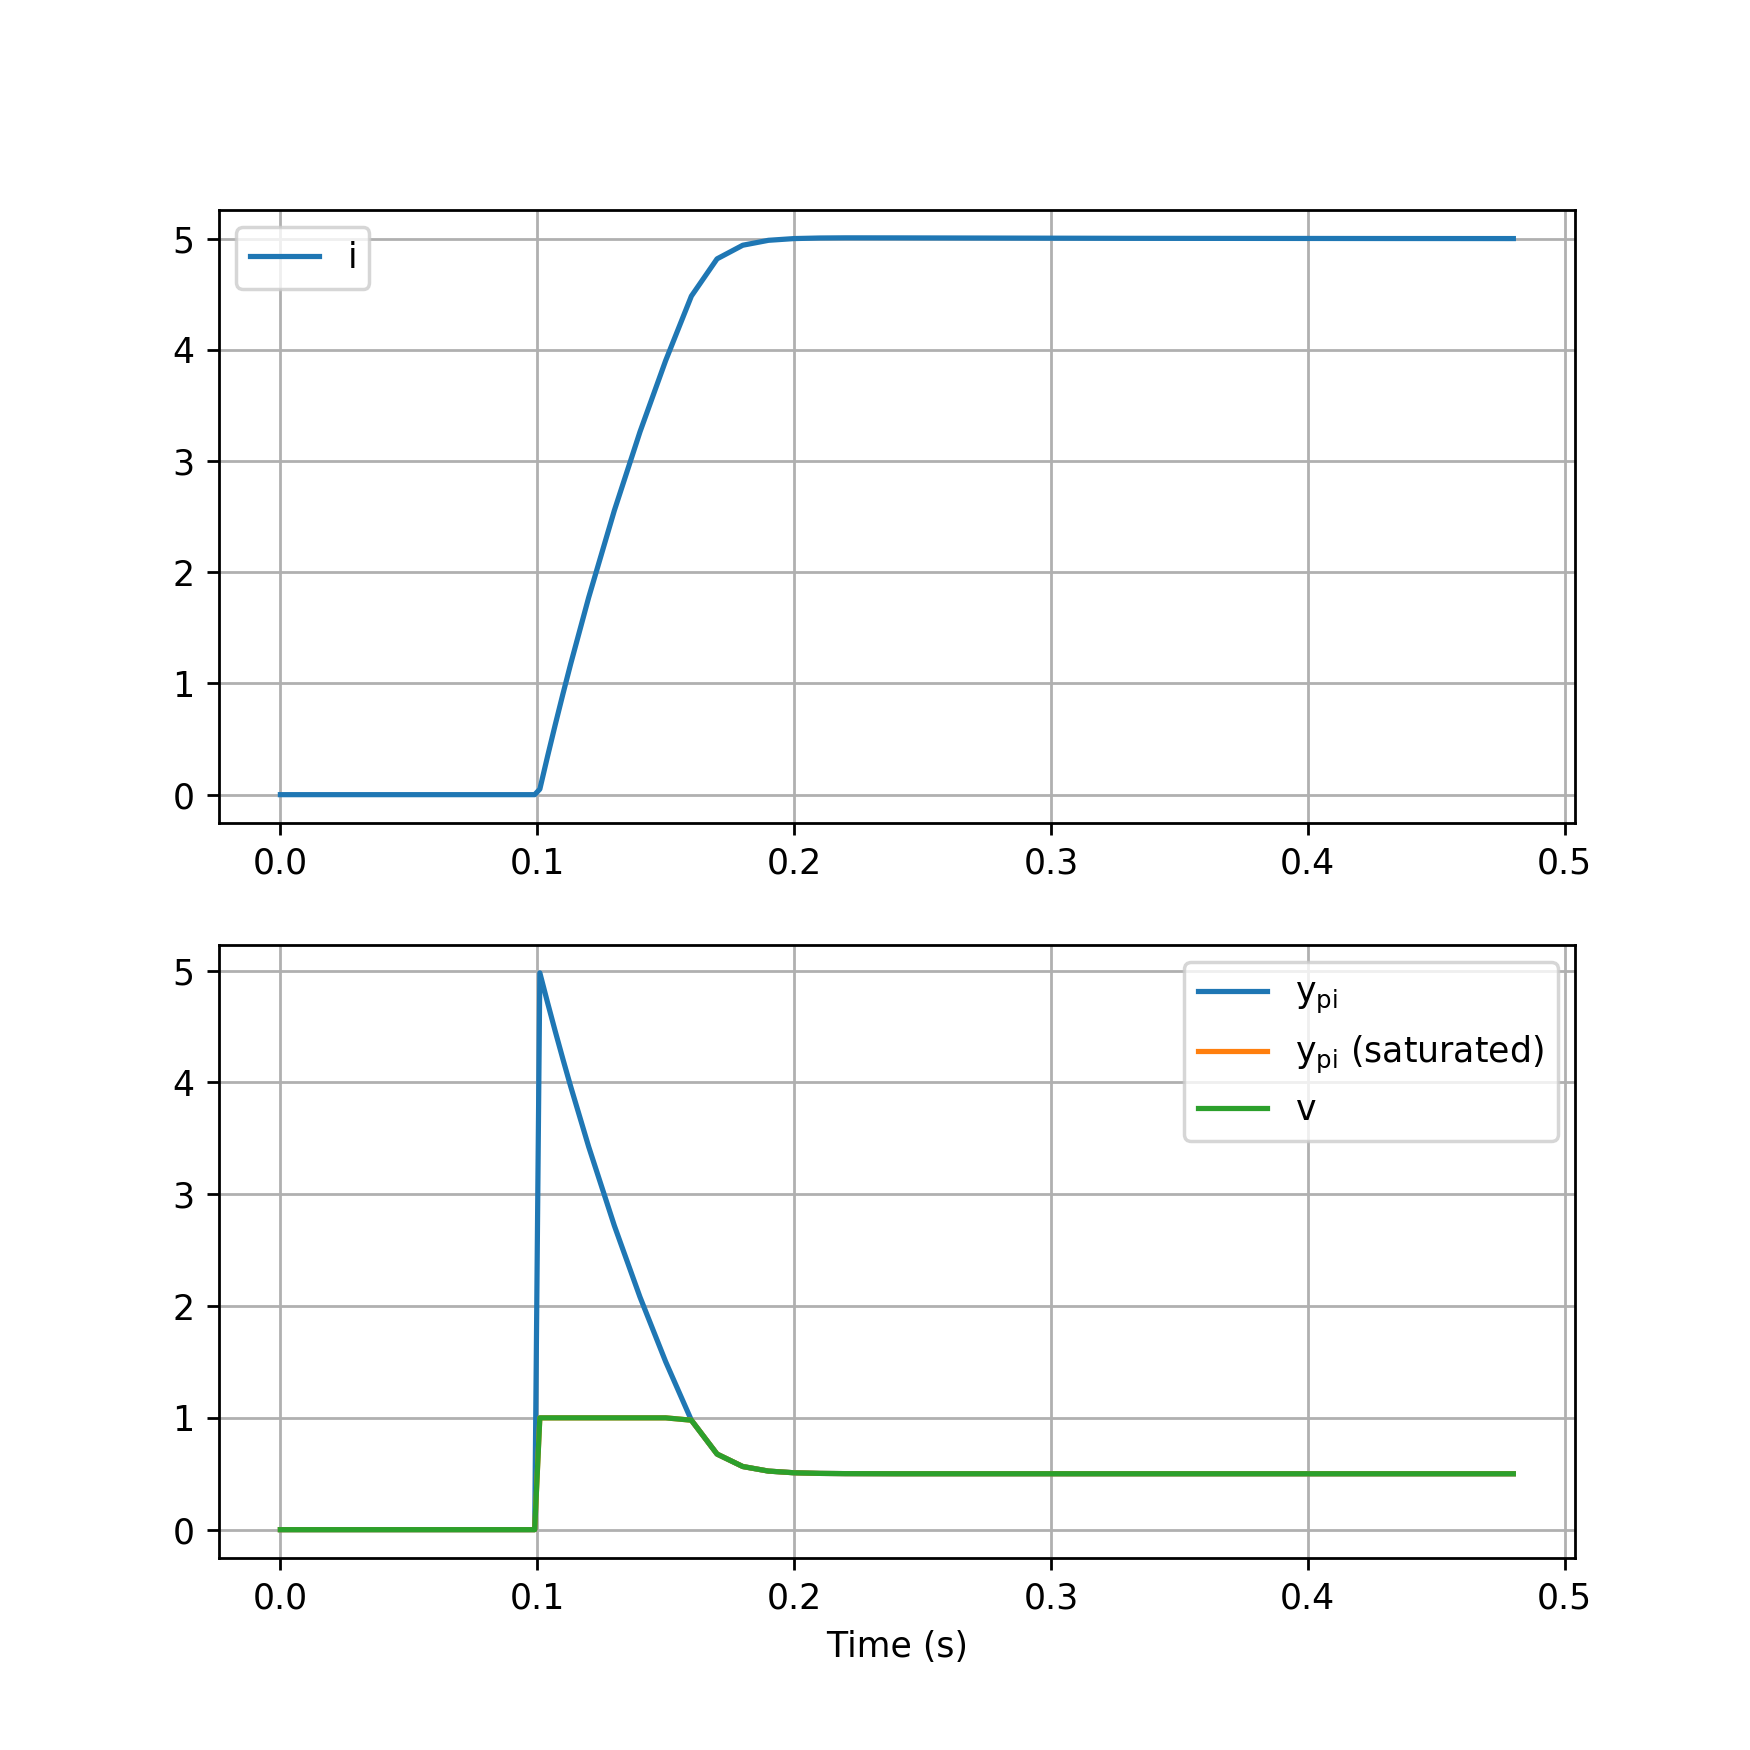

In [14]:
def simulation(o):
    
    # simulation set up
    o.struct[0].itol = 1e-6
    o.struct.it_store = 0
    o.struct.t = 0.0
    
    # find steady-state for i_ref = 0.0
    o.struct.i_ref = 0.0
    optimize.root(o.run_problem, [1]*(o.N_x+o.N_y), jac=o.dae_jacobian, method='hybr')
    

    # run until t=0.1 s with  i_ref = 0.0    
    o.struct.t_end = 0.1
    t = rl_ctrl_sat_aw.daesolver(o.struct)

    # apply i_ref = 5.0  and run until t=0.5 s   
    o.struct.t_end = 0.1
    o.struct.i_ref = 5.0
    o.struct.t_end = 0.5
    t = rl_ctrl_sat_aw.daesolver(o.struct)

    # truncate output vectors 
    T = o.struct[0]['T'][:o.struct[0].it_store]
    X = o.struct[0].X[:o.struct[0].it_store,:]
    Y = o.struct[0].Y[:o.struct[0].it_store,:]
    Z = o.struct[0].Z[:o.struct[0].it_store,:]    
    Iters = o.struct[0].iters[:o.struct[0].it_store,:]  
    
    return T,X,Y,Z,Iters

T,X,Y,Z,Iters = simulation(o)


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
axes[0].plot(T,X[:,0],label='$\sf i$')
axes[1].plot(T,Y[:,0],label='$\sf y_{pi}$')
axes[1].plot(T,Y[:,1],label='$\sf y_{pi}$ (saturated)')
axes[1].plot(T,Z[:,0],label='$\sf v$')
for ax in axes:
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

axes[1].legend(loc='best')

## Run multiple simulations

In [15]:
o = rl_ctrl_sat_aw.rl_ctrl_sat_aw_class()
o.Dt = 0.001
o.t_end = 5.0
o.decimation = 10
o.update()

o.struct.V_max = 1

o.struct.i_ref = 0
sol = optimize.root(o.run_problem, [1]*(o.N_x+o.N_y), jac=o.dae_jacobian, method='hybr')
o.struct.K_aw = 1.0
x_0 = np.copy(o.struct.x)
y_0 = np.copy(o.struct.y)

def sim_iref(o,i_ref):
    
    o.struct.x = np.copy(x_0)
    o.struct.y = np.copy(y_0)
    
    o.struct[0].itol = 1e-6
    o.struct.it_store = 0
    o.struct.t = 0.0
    
    o.struct.i_ref = 0.0
    o.struct.t_end = 0.5
    t = rl_ctrl_sat_aw.daesolver(o.struct)

    o.struct.i_ref = i_ref
    o.struct.t_end = 2.0
    t = rl_ctrl_sat_aw.daesolver(o.struct)
    
    T = o.struct[0]['T'][:o.struct[0].it_store]
    X = o.struct[0].X[:o.struct[0].it_store,:]
    Y = o.struct[0].Y[:o.struct[0].it_store,:]
    Z = o.struct[0].Z[:o.struct[0].it_store,:]
    Iters = o.struct[0].iters[:o.struct[0].it_store,:]    
    return T,X,Y,Z,Iters

<IPython.core.display.Javascript object>


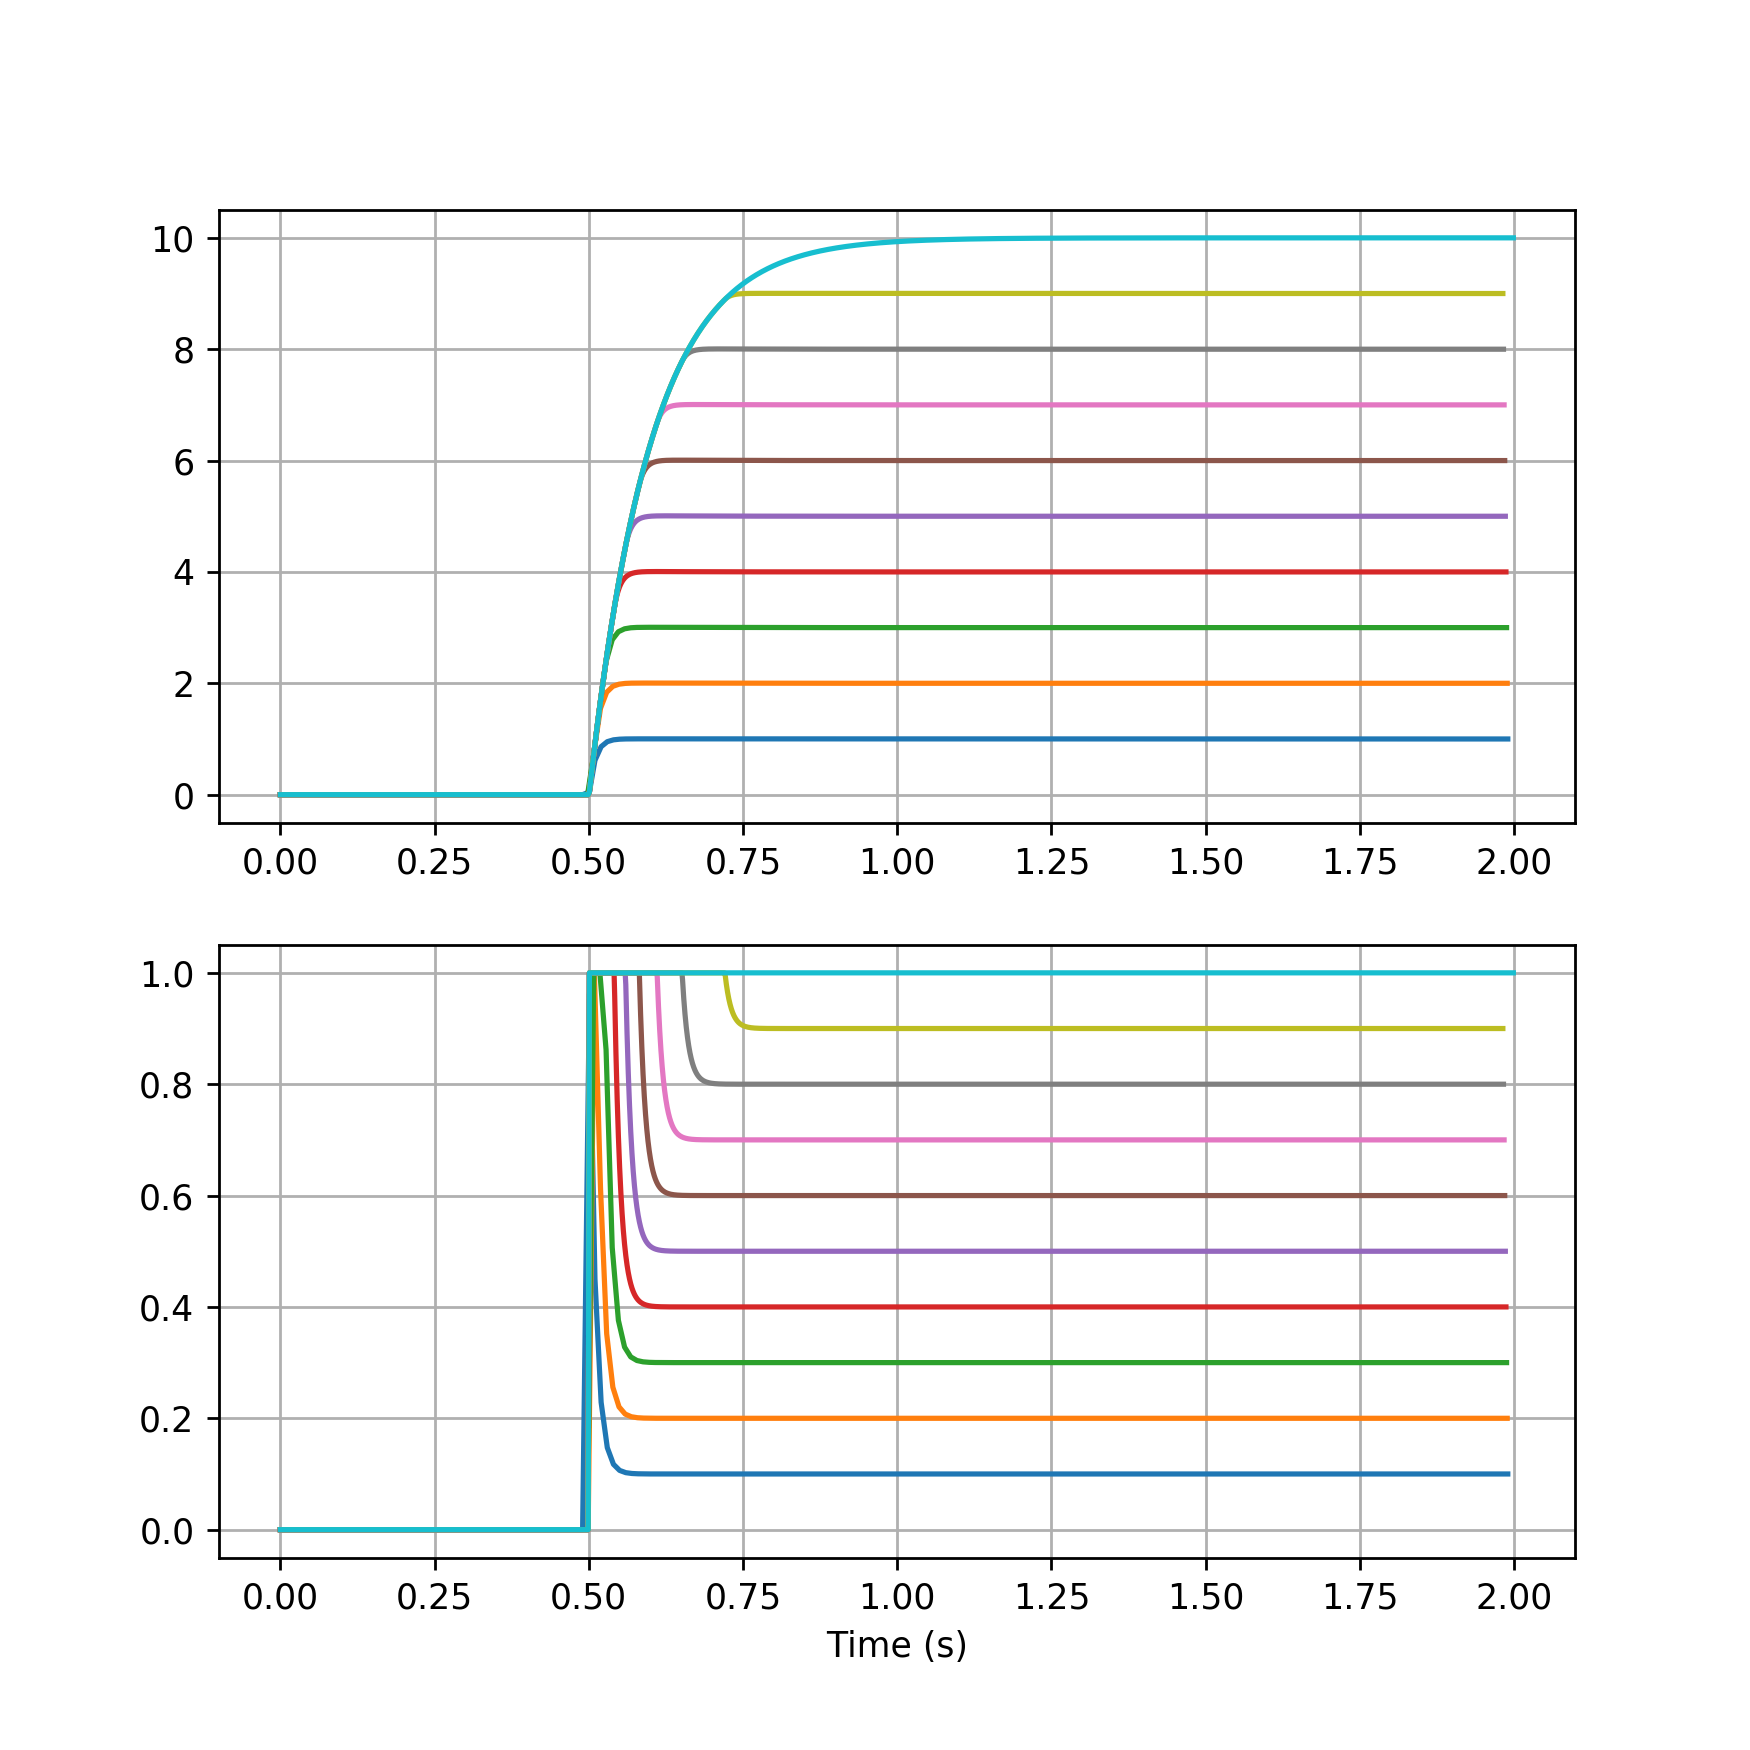

Text(0.5, 0, 'Time (s)')

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
for i_ref in np.arange(1,11):
    T,X,Y,Z,Iters = sim_iref(o,i_ref)
    axes[0].plot(T,X[:,0])
    axes[1].plot(T,Z[:,0])

for ax in axes:
    ax.grid()
    #ax.legend()
ax.set_xlabel('Time (s)')
